In [1]:
# coding: utf-8

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
import math
from math import radians, cos, sin, asin, sqrt
import joblib
import os
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score, davies_bouldin_score

# Basic configuration
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore', category=FutureWarning)

# Directory for saving models
MODEL_DIR = "saved_models_multi"
os.makedirs(MODEL_DIR, exist_ok=True)
print(f"Model saving directory: '{MODEL_DIR}'")

Model saving directory: 'saved_models_multi'


In [2]:
donors_df_full = pd.read_csv('synthetic_donors_profiled.csv', parse_dates=['last_donation_date'])
needs_df = pd.read_csv('synthetic_bank_needs_profiled.csv')
print("Profiled data loaded successfully.")

print("\n--- Donor Data Info (Full) ---")
donors_df_full.info()

Profiled data loaded successfully.

--- Donor Data Info (Full) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950000 entries, 0 to 949999
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   donor_id             950000 non-null  object        
 1   city                 950000 non-null  object        
 2   profile_name         950000 non-null  object        
 3   latitude             950000 non-null  float64       
 4   longitude            950000 non-null  float64       
 5   blood_type           950000 non-null  object        
 6   age                  950000 non-null  int64         
 7   gender               950000 non-null  object        
 8   last_donation_date   825363 non-null  datetime64[ns]
 9   is_eligible          950000 non-null  bool          
 10  availability_status  950000 non-null  bool          
 11  is_regular_donor     950000 non-null  bool          
dtypes: bo

In [3]:
print("\n--- Verifying Loaded Data Ranges ---")

columns_to_check = ['latitude', 'longitude', 'age', 'days_since_last_donation']
existing_check_columns = [col for col in columns_to_check if col in donors_df_full.columns]

if existing_check_columns:
    print(donors_df_full[existing_check_columns].describe())

    lat_min, lat_max = donors_df_full['latitude'].min(), donors_df_full['latitude'].max()
    lon_min, lon_max = donors_df_full['longitude'].min(), donors_df_full['longitude'].max()
    print(f"\nCoord Ranges: Lat ({lat_min:.2f} - {lat_max:.2f}), Lon ({lon_min:.2f} - {lon_max:.2f})")

    if not (29 < lat_min < 33 and 29 < lat_max < 33 and 73 < lon_min < 78 and 73 < lon_max < 78):
         print("\n*** WARNING: Latitude/Longitude values seem outside the expected Punjab region! ***")
         print("*** Please check the 'synthetic_donors_profiled.csv' file or the generation script. ***")
    else:
         print("\nCoordinate ranges appear reasonable for the target region.")
else:
    print("Warning: Could not find columns to describe.")


--- Verifying Loaded Data Ranges ---
            latitude      longitude            age
count  950000.000000  950000.000000  950000.000000
mean       31.023656      75.647268      37.926522
std         0.647620       0.625250      11.761982
min        30.075868      74.713582      18.000000
25%        30.545832      75.058612      28.000000
50%        30.852638      75.612384      37.000000
75%        31.470565      76.068672      47.000000
max        32.403734      76.875067      65.000000

Coord Ranges: Lat (30.08 - 32.40), Lon (74.71 - 76.88)

Coordinate ranges appear reasonable for the target region.


In [4]:
### 3.1 Data Cleaning

print("\n--- Data Cleaning ---")

donors_initial_count = len(donors_df_full)
donors_df_full.drop_duplicates(inplace=True)
print(f"Removed {donors_initial_count - len(donors_df_full)} duplicate donor rows.")

if 'profile_name' in donors_df_full.columns:
    donors_df_full.drop(columns=['profile_name'], inplace=True)
    print("Dropped 'profile_name' column.")


--- Data Cleaning ---
Removed 0 duplicate donor rows.
Dropped 'profile_name' column.


In [5]:
### 3.2 Feature Engineering

print("\n--- Feature Engineering ---")

donors_df_full['last_donation_date'] = pd.to_datetime(donors_df_full['last_donation_date'], errors='coerce')
if pd.api.types.is_datetime64_any_dtype(donors_df_full['last_donation_date']):
    now_ts = pd.Timestamp.now()
    time_diff_series = now_ts - donors_df_full['last_donation_date']
    donors_df_full['days_since_last_donation'] = time_diff_series.dt.days
    donors_df_full['days_since_last_donation'] = donors_df_full['days_since_last_donation'].fillna(9999)
    eligibility_days = 56
    donors_df_full['days_since_last_donation'] = pd.to_numeric(donors_df_full['days_since_last_donation'])
    donors_df_full['is_eligible'] = donors_df_full['days_since_last_donation'] > eligibility_days
    print("Eligibility features engineered.")
else:
    print("Error: Could not convert 'last_donation_date' correctly.")

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r

compatibility = {
    'O-': ['O-', 'O+', 'B-', 'B+', 'A-', 'A+', 'AB-', 'AB+'],
    'O+': ['O+', 'B+', 'A+', 'AB+'],
    'B-': ['B-', 'B+', 'AB-', 'AB+'],
    'B+': ['B+', 'AB+'],
    'A-': ['A-', 'A+', 'AB-', 'AB+'],
    'A+': ['A+', 'AB+'],
    'AB-': ['AB-', 'AB+'],
    'AB+': ['AB+']
}

def is_compatible(donor_type, requested_type):
    if requested_type == "ALL": return True
    if donor_type == requested_type: return True
    if donor_type == 'O-': return True
    if requested_type.endswith('+'):
        if donor_type == requested_type[:-1] + '-': return True
    if requested_type == 'A+' and donor_type in ['A-', 'O-', 'O+']: return True
    if requested_type == 'B+' and donor_type in ['B-', 'O-', 'O+']: return True
    if requested_type == 'AB+' and donor_type in ['A-', 'B-', 'O-', 'O+', 'A+', 'B+', 'AB-']: return True
    if requested_type == 'O+' and donor_type == 'O-': return True
    if requested_type == 'A-' and donor_type == 'O-': return True
    if requested_type == 'B-' and donor_type == 'O-': return True
    if requested_type == 'AB-' and donor_type in ['A-', 'B-', 'O-']: return True
    return False


--- Feature Engineering ---
Eligibility features engineered.


In [6]:
### 3.3 Splitting Data (Conceptual)

indices = donors_df_full.index
train_indices, temp_indices = train_test_split(indices, test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)
print(f"Conceptual split: Train {len(train_indices)}, Val {len(val_indices)}, Test {len(test_indices)}")

Conceptual split: Train 665000, Val 142500, Test 142500


In [7]:
### 3.4 Data Transformation (Scaling)

print("\n--- Scaling Features for Clustering (on Full Data) ---")
features_for_scaling = ['latitude', 'longitude', 'age', 'days_since_last_donation']
existing_features = [f for f in features_for_scaling if f in donors_df_full.columns and pd.api.types.is_numeric_dtype(donors_df_full[f])]
if len(existing_features) != len(features_for_scaling):
    print(f"Warning: Using subset of features for scaling: {existing_features}")

scaler = StandardScaler()
donors_df_scaled = pd.DataFrame(scaler.fit_transform(donors_df_full[existing_features]),
                                columns=existing_features, index=donors_df_full.index)

print(f"Scaled features ({existing_features}) created using StandardScaler.")
print("Scaler fitted on the full dataset.")

scaler_path = os.path.join(MODEL_DIR, 'scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

data_for_clustering = donors_df_scaled[existing_features]  # Final data used for clustering

EVAL_SAMPLE_SIZE = min(50000, len(data_for_clustering))
eval_sample_indices = data_for_clustering.sample(n=EVAL_SAMPLE_SIZE, random_state=42).index


--- Scaling Features for Clustering (on Full Data) ---
Scaled features (['latitude', 'longitude', 'age', 'days_since_last_donation']) created using StandardScaler.
Scaler fitted on the full dataset.
Scaler saved to saved_models_multi\scaler.joblib


In [8]:
### 3.5 Verify Scaled Data Ranges

print("\n--- Verifying Scaled Data Ranges ---")
print(data_for_clustering.describe())

max_abs_scaled = data_for_clustering.abs().max().max()  # Check max absolute value post-scaling
print(f"\nMax absolute scaled value: {max_abs_scaled:.2f}")
if max_abs_scaled > 10:
    print("*** Warning: Very large values found after scaling. May indicate extreme outliers influencing the scaler. ***")


--- Verifying Scaled Data Ranges ---
           latitude     longitude           age  days_since_last_donation
count  9.500000e+05  9.500000e+05  9.500000e+05              9.500000e+05
mean   7.839603e-15 -1.427293e-14 -1.950141e-16             -1.304407e-17
std    1.000001e+00  1.000001e+00  1.000001e+00              1.000001e+00
min   -1.463495e+00 -1.493302e+00 -1.694147e+00             -4.830963e-01
25%   -7.378150e-01 -9.414738e-01 -8.439502e-01             -4.428095e-01
50%   -2.640707e-01 -5.579325e-02 -7.877266e-02             -3.774962e-01
75%    6.900797e-01  6.739774e-01  7.714246e-01             -2.978383e-01
max    2.131001e+00  1.963694e+00  2.301780e+00              2.568320e+00

Max absolute scaled value: 2.57


In [9]:
### 4. Train & Evaluate Multiple Clustering Models

clustering_results = {}

# --- Evaluation Function ---
# (Keep the evaluate_clustering function as defined previously)
def evaluate_clustering(model_name, labels, data):
    """Calculates Silhouette and Davies-Bouldin scores on appropriate data/sample."""
    try:
        if len(labels) < len(data):
            eval_indices = labels.index
            sample_data = data.loc[eval_indices]
            sample_labels = labels
        else:
            sample_data = data.loc[eval_sample_indices]
            sample_labels = labels[eval_sample_indices]

        valid_indices = sample_labels != -1
        if (~valid_indices).any():
            print(f"  (Excluding {np.sum(~valid_indices)} noise points from score calculation)")
            sample_data = sample_data[valid_indices]
            sample_labels = sample_labels[valid_indices]

        if len(np.unique(sample_labels)) < 2:
            print("  Not enough clusters found (or only noise) to calculate scores.")
            return -1, float('inf')

        silhouette = silhouette_score(sample_data, sample_labels)
        davies_bouldin = davies_bouldin_score(sample_data, sample_labels)
        print(f"  Silhouette Score (on sample): {silhouette:.4f}")
        print(f"  Davies-Bouldin Score (on sample): {davies_bouldin:.4f}")
        return silhouette, davies_bouldin
    except Exception as e:
        print(f"  Error during evaluation for {model_name}: {e}")
        return -1, float('inf')


In [11]:
### 4.1 KMeans (Run on Full Data)

print("\n--- Training KMeans ---")
chosen_k = 8
print(f"Using K = {chosen_k}")
kmeans = KMeans(n_clusters=chosen_k, init='k-means++', n_init=10, random_state=42)

kmeans_labels_full = kmeans.fit_predict(data_for_clustering)
print(f"\nEvaluating KMeans (K={chosen_k}) on standard sample...")

kmeans_silhouette, kmeans_db = evaluate_clustering("KMeans", pd.Series(kmeans_labels_full, index=data_for_clustering.index), data_for_clustering)
clustering_results['KMeans'] = {'model': kmeans, 'labels': kmeans_labels_full, 'silhouette': kmeans_silhouette, 'db': kmeans_db, 'k': chosen_k}


--- Training KMeans ---
Using K = 8

Evaluating KMeans (K=8) on standard sample...
  Silhouette Score (on sample): 0.4851
  Davies-Bouldin Score (on sample): 0.7619


In [12]:
### 4.2 MiniBatchKMeans (Run on Full Data)

print("\n--- Training MiniBatchKMeans ---")
minibatch_kmeans = MiniBatchKMeans(n_clusters=chosen_k, init='k-means++', n_init=10, random_state=42, batch_size=1024*2)

minibatch_labels_full = minibatch_kmeans.fit_predict(data_for_clustering)
print(f"\nEvaluating MiniBatchKMeans (K={chosen_k}) on standard sample...")

minibatch_silhouette, minibatch_db = evaluate_clustering("MiniBatchKMeans", pd.Series(minibatch_labels_full, index=data_for_clustering.index), data_for_clustering)
clustering_results['MiniBatchKMeans'] = {'model': minibatch_kmeans, 'labels': minibatch_labels_full, 'silhouette': minibatch_silhouette, 'db': minibatch_db, 'k': chosen_k}


--- Training MiniBatchKMeans ---


C:\Users\Ankush Kumar Ray\.conda\envs\tf-gpu\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 6144 or by setting the environment variable OMP_NUM_THREADS=8
  warnings.warn(



Evaluating MiniBatchKMeans (K=8) on standard sample...
  Silhouette Score (on sample): 0.4580
  Davies-Bouldin Score (on sample): 0.8777



--- Training DBSCAN ---
Creating sample of size 75000 for DBSCAN fitting...
Estimating DBSCAN eps using k-distance plot on the sample...
Using min_samples = 8


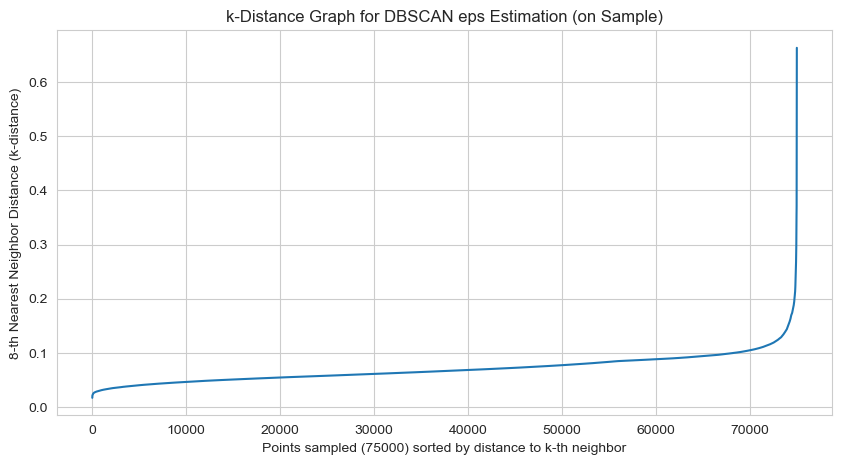

Setting eps = 0.15
Fitting DBSCAN on 75000 samples...
DBSCAN fitting on sample complete.

Evaluating DBSCAN (eps=0.15, min_samples=8) on the sample...
  (Excluding 281 noise points from score calculation)


In [ ]:
### 4.3 DBSCAN (Run on Sample due to Memory)

print("\n--- Training DBSCAN ---")

# Run DBSCAN on a SAMPLE
dbscan_sample_size = 75000  # Adjust size based on your RAM
print(f"Creating sample of size {dbscan_sample_size} for DBSCAN fitting...")
dbscan_sample_data = data_for_clustering.sample(n=dbscan_sample_size, random_state=42)

# Estimate eps using k-distance plot on the sample
print("Estimating DBSCAN eps using k-distance plot on the sample...")
min_samples = 2 * len(existing_features)  # Rule of thumb: 2 * dimensions
print(f"Using min_samples = {min_samples}")

# Fit NearestNeighbors on the DBSCAN sample
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(dbscan_sample_data)
distances, indices = nbrs.kneighbors(dbscan_sample_data)
k_distances = np.sort(distances[:, min_samples-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.xlabel(f"Points sampled ({dbscan_sample_size}) sorted by distance to k-th neighbor")
plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance (k-distance)")
plt.title("k-Distance Graph for DBSCAN eps Estimation (on Sample)")
plt.grid(True)
plt.show()

# Set DBSCAN parameters
estimated_eps = 0.15  # Adjust manually based on k-distance plot
print(f"Setting eps = {estimated_eps}")

dbscan = DBSCAN(eps=estimated_eps, min_samples=min_samples, n_jobs=-1)

# Fit DBSCAN on the sample
print(f"Fitting DBSCAN on {dbscan_sample_size} samples...")
dbscan_sample_labels = dbscan.fit_predict(dbscan_sample_data)
print("DBSCAN fitting on sample complete.")

# Evaluate DBSCAN using the sample data and its labels
print(f"\nEvaluating DBSCAN (eps={estimated_eps}, min_samples={min_samples}) on the sample...")
dbscan_silhouette, dbscan_db = evaluate_clustering("DBSCAN", pd.Series(dbscan_sample_labels, index=dbscan_sample_data.index), dbscan_sample_data)

# Report DBSCAN specific metrics from the sample
n_clusters_db = len(set(dbscan_sample_labels)) - (1 if -1 in dbscan_sample_labels else 0)
n_noise_db = list(dbscan_sample_labels).count(-1)
noise_percentage = (n_noise_db / len(dbscan_sample_labels)) * 100
print(f"  Clusters found in sample: {n_clusters_db}")
print(f"  Noise points found in sample: {n_noise_db} ({noise_percentage:.2f}%)")

# Store results
clustering_results['DBSCAN'] = {'model': dbscan, 'labels': dbscan_sample_labels, 'silhouette': dbscan_silhouette, 'db': dbscan_db, 'n_clusters': n_clusters_db, 'noise_perc': noise_percentage, 'trained_on_sample': True}


--- Selecting Best Clustering Model ---

Model Comparison:
- KMeans:
  Silhouette = 0.4851 
  Davies-Bouldin = 0.7619 
  K = 8
- MiniBatchKMeans:
  Silhouette = 0.4580 
  Davies-Bouldin = 0.8777 
  K = 8
- DBSCAN:
  Silhouette = 0.4116 (Sample)
  Davies-Bouldin = 0.7004 (Sample)
  Clusters Found = 27 (Sample)
  Noise = 0.92% (Sample)

*** MANUAL OVERRIDE: Selecting DBSCAN due to KMeans visualization issues. ***
Manually selected 'DBSCAN' with Silhouette (sample): 0.4116, DB (sample): 0.7004

Selected 'DBSCAN' as the best available clustering model.
Best clustering model (DBSCAN) saved to saved_models_multi\best_cluster_model.joblib
Scaler was saved earlier to: saved_models_multi\scaler.joblib
DBSCAN labels are for the sample only and not assigned to the full dataframe.

Visualizing Best Clusters (DBSCAN Sample)...


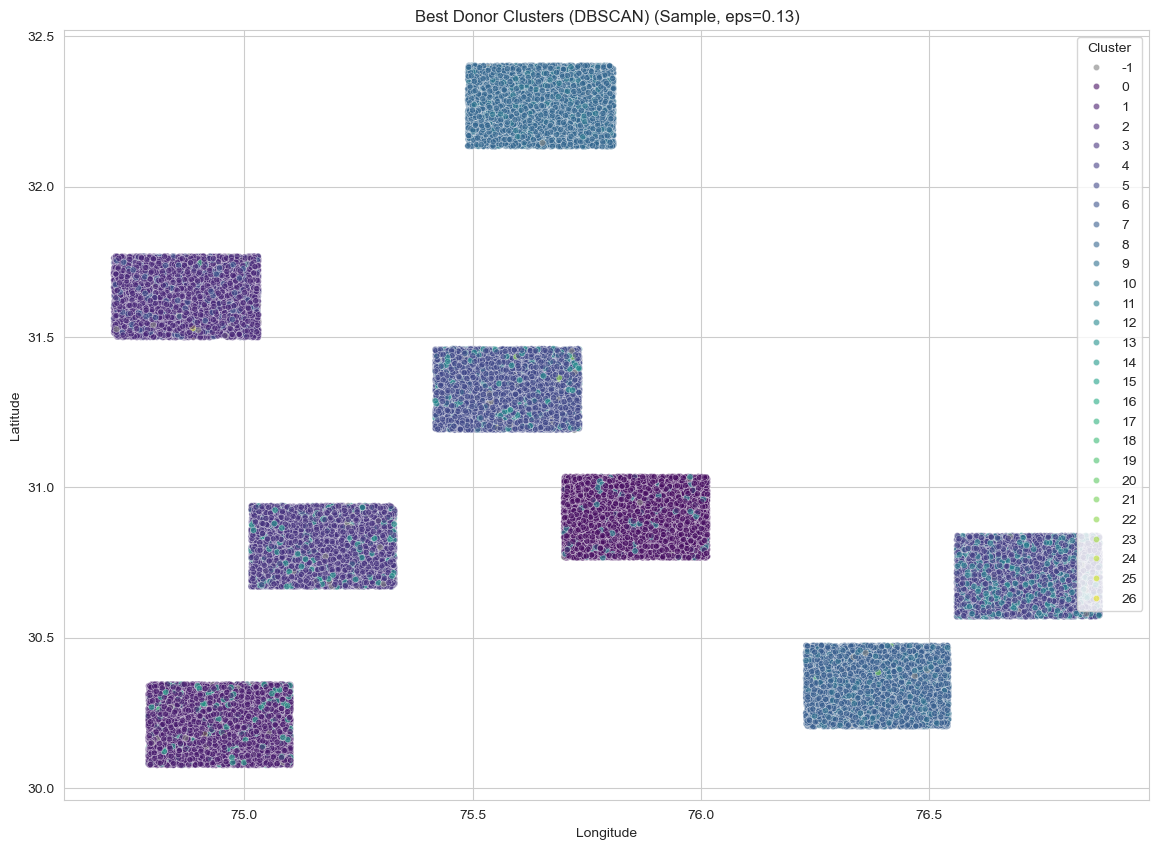

In [14]:
## 5. Select and Save Best Clustering Model & Scaler

print("\n--- Selecting Best Clustering Model ---")

best_model_name = None
best_silhouette = -1
best_model_object = None
best_labels = None
trained_on_sample = False

print("\nModel Comparison:")
for name, result in clustering_results.items():
    print(f"- {name}:")
    print(f"  Silhouette = {result['silhouette']:.4f}", "(Sample)" if result.get('trained_on_sample') else "")
    print(f"  Davies-Bouldin = {result['db']:.4f}", "(Sample)" if result.get('trained_on_sample') else "")
    if 'k' in result: print(f"  K = {result['k']}")
    if 'n_clusters' in result: print(f"  Clusters Found = {result['n_clusters']}", "(Sample)" if result.get('trained_on_sample') else "")
    if 'noise_perc' in result: print(f"  Noise = {result['noise_perc']:.2f}%", "(Sample)" if result.get('trained_on_sample') else "")

# MANUAL OVERRIDE: Select DBSCAN
print("\n*** MANUAL OVERRIDE: Selecting DBSCAN due to KMeans visualization issues. ***")
if 'DBSCAN' in clustering_results:
    dbscan_result = clustering_results['DBSCAN']
    if dbscan_result.get('n_clusters', 0) >= 1:
         best_model_name = 'DBSCAN'
         best_silhouette = dbscan_result['silhouette']
         best_model_object = dbscan_result['model']
         best_labels = dbscan_result['labels']
         trained_on_sample = dbscan_result.get('trained_on_sample', False)
         print(f"Manually selected '{best_model_name}' with Silhouette (sample): {best_silhouette:.4f}, DB (sample): {dbscan_result['db']:.4f}")
    else:
        print("Error: DBSCAN did not find enough clusters during manual selection.")
        best_model_name = None
else:
    print("Error: DBSCAN results not found for manual selection.")
    best_model_name = None

if best_model_name == 'DBSCAN': 
    print(f"\nSelected '{best_model_name}' as the best available clustering model.")

    best_model_path = os.path.join(MODEL_DIR, 'best_cluster_model.joblib')
    joblib.dump(best_model_object, best_model_path)
    print(f"Best clustering model ({best_model_name}) saved to {best_model_path}")
    print(f"Scaler was saved earlier to: {scaler_path}")

    print("DBSCAN labels are for the sample only and not assigned to the full dataframe.")

    # Visualization (Adjusted for DBSCAN Sample)
    print("\nVisualizing Best Clusters (DBSCAN Sample)...")
    plt.figure(figsize=(14, 10))

    plot_data = dbscan_sample_data.copy() 
    plot_data[existing_features] = scaler.inverse_transform(plot_data[existing_features]) 
    plot_data['best_cluster'] = best_labels

    hue_order = sorted(plot_data['best_cluster'].unique())
    palette_name = "viridis"
    if -1 in hue_order:
        n_colors_needed = max(0, len(hue_order)-1)
        if n_colors_needed > 0:
             custom_palette_list = sns.color_palette(palette_name, n_colors=n_colors_needed)
             custom_palette = {label: color for label, color in zip(sorted(l for l in hue_order if l != -1), custom_palette_list)}
        else:
             custom_palette = {}
        custom_palette[-1] = 'grey'; palette_to_use = custom_palette
    else:
        palette_to_use = sns.color_palette(palette_name, n_colors=len(hue_order))

    sns.scatterplot(data=plot_data, x='longitude', y='latitude', hue='best_cluster',
                    palette=palette_to_use, hue_order=hue_order,
                    s=20, alpha=0.6, legend='full')

    plt.title(f'Best Donor Clusters ({best_model_name}) (Sample, eps={best_model_object.eps:.2f})')
    plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.legend(title='Cluster'); plt.show()

else:
    print("\nCould not select a best model. No model saved.")


In [15]:
## 5b. Train Proxy Classifier for DBSCAN Labels (KNN)
# This step is needed because DBSCAN itself doesn't predict on new points easily.
# We train a KNN classifier on the sample data using the DBSCAN labels as targets.

if best_model_name == 'DBSCAN' and best_labels is not None:
    print("\n--- Training KNN Classifier to Predict DBSCAN Clusters ---")
    from sklearn.neighbors import KNeighborsClassifier

    # Data: The scaled sample data DBSCAN was trained on
    X_knn_train = dbscan_sample_data  # Already scaled features from the sample
    y_knn_train = best_labels  # DBSCAN labels for the sample

    # Filter out noise points for training the KNN (it can't predict noise easily)
    non_noise_indices = y_knn_train != -1
    X_knn_train_filtered = X_knn_train[non_noise_indices]
    y_knn_train_filtered = y_knn_train[non_noise_indices]

    if len(X_knn_train_filtered) > 0:
        print(f"Training KNN classifier on {len(X_knn_train_filtered)} non-noise sample points...")
        knn_predictor = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
        knn_predictor.fit(X_knn_train_filtered, y_knn_train_filtered)
        print("KNN classifier trained.")

        # Save the KNN predictor model
        knn_predictor_path = os.path.join(MODEL_DIR, 'knn_cluster_predictor.joblib')
        joblib.dump(knn_predictor, knn_predictor_path)
        print(f"KNN cluster predictor saved to {knn_predictor_path}")

    else:
        print("Warning: No non-noise data points found from DBSCAN sample to train KNN predictor.")
        knn_predictor = None
        knn_predictor_path = None
else:
    print("\nSkipping KNN predictor training (Best model was not DBSCAN or labels missing).")
    knn_predictor = None
    knn_predictor_path = None


--- Training KNN Classifier to Predict DBSCAN Clusters ---
Training KNN classifier on 74313 non-noise sample points...
KNN classifier trained.
KNN cluster predictor saved to saved_models_multi\knn_cluster_predictor.joblib


In [16]:
# %% [markdown]
# ## 6. Define Recommendation/Matching Logic (Content-Based + NN)
# The function definition remains the same, it uses the processed `donors_df_full` implicitly when called later.

print("\n--- Defining Matching/Recommendation Function ---")

def find_matching_donors(bank_need_row, all_donors_df_unscaled, max_distance_km=50, top_n=20):
    """
    Finds and ranks eligible, compatible donors for a bank need.
    Assumes input dataframe has original scale features needed.
    """
    bank_lat = bank_need_row['latitude']
    bank_lon = bank_need_row['longitude']
    required_type = bank_need_row['required_blood_type']
    required_units = bank_need_row['required_units']

    candidate_donors = all_donors_df_unscaled.copy()

    candidate_donors = candidate_donors[candidate_donors['is_eligible']]
    if candidate_donors.empty: return pd.DataFrame()
    candidate_donors['compatible'] = candidate_donors['blood_type'].apply(lambda dt: is_compatible(dt, required_type))
    candidate_donors = candidate_donors[candidate_donors['compatible']]
    if candidate_donors.empty: return pd.DataFrame()
    if 'availability_status' in candidate_donors.columns:
       candidate_donors = candidate_donors[candidate_donors['availability_status'] == True]
       if candidate_donors.empty: return pd.DataFrame()

    candidate_donors['distance_km'] = candidate_donors.apply(
        lambda donor: haversine(bank_lon, bank_lat, donor['longitude'], donor['latitude']),
        axis=1
    )

    nearby_donors = candidate_donors[candidate_donors['distance_km'] <= max_distance_km].copy()
    if nearby_donors.empty: return pd.DataFrame()
    nearby_donors.sort_values(by=['distance_km', 'is_regular_donor', 'days_since_last_donation'], ascending=[True, False, False], inplace=True)

    num_to_return = max(top_n, int(required_units * 1.5))
    num_to_return = min(num_to_return, top_n)
    return nearby_donors.head(num_to_return)

print("Matching function defined.")


--- Defining Matching/Recommendation Function ---
Matching function defined.


In [17]:
# %% [markdown]
# ## 7. Evaluate Matching Logic (Simulation)

# %%
# Simulates matching needs against the full donor pool to evaluate performance

print("\n--- Matching System Evaluation (Simulation) ---")
eval_needs_sample = needs_df.sample(n=min(100, len(needs_df)), random_state=123)
print(f"Evaluating matching performance on {len(eval_needs_sample)} needs...")

results = []
search_radius_km = 50

# Prepare unscaled donor data for matching
donors_df_unscaled_for_match = donors_df_full.copy()
donors_df_unscaled_for_match[existing_features] = scaler.inverse_transform(donors_df_full[existing_features])

for index, need_row in eval_needs_sample.iterrows():
    matches = find_matching_donors(need_row, donors_df_unscaled_for_match,
                                   max_distance_km=search_radius_km, top_n=50)
    match_found = not matches.empty
    top_donor_distance = matches['distance_km'].iloc[0] if match_found else None
    num_matches = len(matches) if match_found else 0
    required = need_row['required_units']
    potential_fulfillment = num_matches / required if match_found and required > 0 else 0
    results.append({ 'need_id': need_row.name, 'match_found': match_found, 'num_matches_found': num_matches, 'top_donor_distance_km': top_donor_distance, 'potential_fulfillment_ratio': potential_fulfillment })

eval_results_df = pd.DataFrame(results)

# Calculate performance metrics
total_needs_evaluated = len(eval_results_df)
num_needs_matched = eval_results_df['match_found'].sum()
match_rate = (num_needs_matched / total_needs_evaluated) * 100 if total_needs_evaluated > 0 else 0
avg_top_donor_distance = eval_results_df.loc[eval_results_df['match_found'], 'top_donor_distance_km'].mean()
avg_potential_fulfillment = eval_results_df.loc[eval_results_df['match_found'], 'potential_fulfillment_ratio'].mean()

print(f"\n--- Matching Evaluation Summary (Radius: {search_radius_km} km) ---")
print(f"Match Rate: {match_rate:.2f}%")
print(f"Average Distance of Top Match: {avg_top_donor_distance:.2f} km")
print(f"Average Potential Fulfillment Ratio: {avg_potential_fulfillment:.2f}")


print("\nNotebook execution complete.")


--- Matching System Evaluation (Simulation) ---
Evaluating matching performance on 100 needs...

--- Matching Evaluation Summary (Radius: 50 km) ---
Match Rate: 0.00%
Average Distance of Top Match: nan km
Average Potential Fulfillment Ratio: nan

Notebook execution complete.
